# Büyük Veri Setleri Üzerinde Veri Madenciliği - FİNAL SINAVI PROJESİ

### Author: Süheyl Çavuşoğlu

## Konu: Bir sorgu yüz görüntüsüne en yakın k-adet yüz görüntüsünün bulunması

#### Çözüm adımları:
- 1- Görüntülerden sete (kümeye) dönüşüm
- 2- Ön işlem: Görüntüye ait büyük seti, benzerlik özelliğini kaybetmeyecek şekilde bir imzaya dönüştürme (min-hashing)
- 3- Aday belirleme: LSH (Locality-Sensitive Hashing) ile aday benzeleri bulma
- 4- Bir uzaklık veya benzerlik metriğine göre top-k benzer yüz görüntüsünü geri döndürme
- Kullanılacak veriseti: https://www.kaggle.com/datasets/atulanandjha/lfwpeople



In [2]:
!pip install datasketch

  Using cached datasketch-1.5.9-py3-none-any.whl (76 kB)


- İlk olarak çalışmada kullanılacak kütüphaneleri import ettim.

In [3]:
import numpy as np
import cv2
import os
import tarfile
from datasketch import MinHash, MinHashLSH

In [4]:
# Yukarıdaki kaggle bağlantısına tıklayarak veri setini, çalışma dizinime indirdim. 
with tarfile.open('lfw-funneled.tgz', 'r:gz') as tar:  # çalışma dizininde bulunan 'lfw-funneled.tgz' isimli dosyayı açtım.
    tar.extractall(path='./')  #  'lfw-funneled.tgz' isimli dosyanın içerisindeki dosyaları bir klasöre çıkarttım (extract ettim).

faces = [] # çıkardığım dosyaların içerisinde bulunan görüntülerdeki yüzleri tutmam gerekiyor. Bunun için boş bir liste hazırladım.

# aşağıdakki for döngüleri ile dosyaları okudum ve .jpg dosyalarında bulunan yüzleri listeye ekledim.
for root, dirs, files in os.walk('lfw_funneled'): # os modülünü kullanarak tüm dosyaları for döngüsü ile okudum.
    for file in files:
        if file.endswith('.jpg'):
            img_path = os.path.join(root, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # boyutu azalttığı, işlemleri hızlandırdığı ve bazı makine öğrenmesi algoritmaları daha iyi performans gösterdiği için görüntüyü gri tonlama şeklinde okuttum.
            img = cv2.resize(img, (64, 64))  # genelde 64x64 yeterli olduğu için görüntü boyutunu bu şekilde değiştirdim.
            img = img / 255.0
            faces.append(img)

# okuduğum yüz görüntülerini numpy array'ine çevirdim.
faces = np.array(faces)

print('Toplam yüz sayısı:', len(faces)) # indirdiğim veri setinden okuduğum toplam yüz sayısını ekrana yazdırdım.
print('Her bir yüzün boyutu:', faces[0].shape) # bu yüzlerin boyutlarını kontrol ettim.

Toplam yüz sayısı: 13233
Her bir yüzün boyutu: (64, 64)


Yukarıdaki kod bloğunu çalıştırarak, toplamda 13233 adet yüz görüntüsünün olduğunu belirleyebildik ve belirlediğimiz yüz görüntülerinin her birinin boyutunun (64,64) olduğunu gördük. Bunun anlamı tüm görüntülerin 64x64 (toplamda 4096) piksele sahip bir 2D görüntü olmasıdır.
- Şimdi okuduğumuz yüzlerin MinHash imzalarını oluşturabiliriz.

In [5]:
minhash_signatures = [] # MinHash imzalarını bir arada tutmak için boş bir liste hazırladım, imzaları bu listede saklayacağım.

# Her bir görüntü için bir MinHash imzası oluşturmak amacıyla bir for loop'u kullandım.
for face in faces:
    m = MinHash() # imzalar için datasketch kütüphanesinden MinHash'i kullandım.
    for pixel in face.flatten():
        m.update(str(pixel).encode('utf8'))  
    minhash_signatures.append(m) # görüntüleri tek tek gezerek her bir görüntünün her bir pixel değerini MinHash nesnesine ekledim.

print('Toplam MinHash imza sayısı:', len(minhash_signatures)) # hazırladığım imzaları ve sayılarını kontrol ettim.
print('Bir MinHash imzası:', minhash_signatures[0])

Toplam MinHash imza sayısı: 13233
Bir MinHash imzası: <datasketch.minhash.MinHash object at 0x000001F18AFDAD30>


- Yukarıdaki kod bloğunu çalıştırdığımızda her bir yüz görüntüsü için bir MinHash imzası oluşturmuş olduk. Toplamda 13233 MinHash imzası elde ettik. Yani her bir yüz görüntüsü için bir MinHash imzası sorunsuz bir şekilde oluşmuş demektir.
- MinHash imzasının kendisi, bir Python nesnesi olarak gösteriliyor ve doğrudan yazdırılamıyor, ancak onun üzerinde çeşitli işlemler gerçekleştirebiliriz.

In [6]:
# benzer adayları bulabilmek için Jaccard benzerliğini kullanabiliriz. Jaccard benzerliği, iki küme arasındaki benzerliğin bir ölçüsüdür. İki kümenin kesişim boyutunun iki kümenin birleşiminin boyutuna bölünmesiyle hesaplanır.
# datasketch kütüphanesinden MinHashLSH, Jaccard benzerliğini kullandığı için MinHashLSH ile devam ettim. MinHashLSH ile ilgili biraz bilgi vermek gerekirse;

# MinHashLSH(), her set için bir minhash imzası oluşturarak çalışır. Bir minhash imzası, kümeye uygulanan her bir hash fonksiyonunun minimum değerlerinin bir vektörüdür. Bir küme için minhash imzası o kümeye özgüdür.

# MinHashLSH() benzer kümeleri bulmak için bölgeye duyarlı bir karma işlevi (LSH - Locality-Sensitive Hashing) kullanır. LSH, büyük bir veri kümesinde benzer öğeleri bulmak için kullanılan bir tekniktir. 
# Birden çok karma işlevi olan bir karma tablo oluşturarak çalışır. Her hash işlevi, bir öğeyi bir bucket'a (kovaya) eşler. Benzer öğelerin aynı kovaya hashlenmesi daha olasıdır.
# MinHashLSH(), benzer minhash imzalarına sahip kümeleri bulmak için LSH'yi kullanır. Benzer olduğu bulunan kümelere daha sonra "yakın komşular" denir.


# datasketch kütüphanesinden MinHashLSH'i kullanarak bir LSH modeli oluşturdum. Bu modele 2 parametre verdim. 
# bu parametrelerden ilki yani threshold, Jaccard benzerliği için eşik değeri, num_perm ise minhash imzalarını oluşturmak için kullanılan permütasyonların sayısıdır. 
# Ne kadar çok permütasyon kullanılırsa, minhash imzaları o kadar doğru olur, ancak MinHashLSH() da o kadar yavaş olur.
lsh = MinHashLSH(threshold=0.85, num_perm=128)

# bir for loop'u yardımıyla MinHash imzalarını oluşturduğum LSH modeline ekledim.
for i, minhash in enumerate(minhash_signatures):
    lsh.insert(i, minhash)

print("LSH modeli oluşturuldu ve MinHash imzaları eklendi.")

LSH modeli oluşturuldu ve MinHash imzaları eklendi.


- Yukarıdaki kod bloğu ile MinHash imzalarını LSH modeline ekledik. Bu, benzer MinHash imzalarını aynı bucket'a yerleştirmemizi ve böylece benzer yüz görüntülerini hızlı bir şekilde bulmamızı sağlamaktadır.

In [7]:
# minhash imzalarını bir araya toplamıştık
# şimdi de en yakın minhash imzalarının indekslerini bulalım.
indexes = lsh.query(minhash_signatures[100]) 

# en yakın minhash imzalarının indekslerini kullanarak en yakın yüz görüntülerini bulabiliriz.
similar_faces = faces[indexes]

print('En yakın yüz görüntülerinin sayısı:', len(similar_faces)) # bulduğumuz  yakın yüzlerin sayısını kontrol ettim.

En yakın yüz görüntülerinin sayısı: 9721


- Sonuç olarak, belirli bir yüz görüntüsüne (ben burada 100. indeksteki yüz görüntüsünü seçtim) en yakın olan yüz görüntülerini bulduk. Çıktıya göre, toplamda 9721 yüz görüntüsü, 100. indeksteki yüz görüntüsüne "yeterince benzer" bulundu. Bu, belirlediğimiz Jaccard benzerlik eşiğine bağlıdır ve eşik değeri ne kadar düşük olursa, daha fazla sayıda yüz görüntüsü "benzer" olarak kabul edilir. (Örneğin threshold değerini 0.85 seçmek yerine 0.5 seçtiğim durumda neredeyse tüm yüzler birbirine benzer olarak bulunuyor)

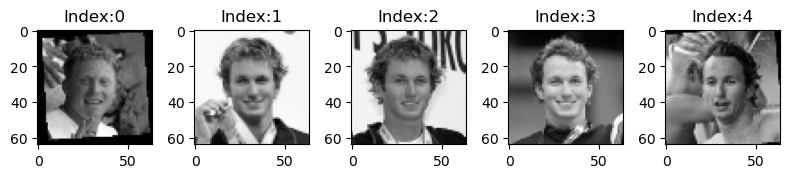

In [16]:
# 100. indeksteki yüz görüntüsüne en çok benzeyen 5 görüntüyü çizdirmek için aşağıdaki kodları kullandım.
import matplotlib.pyplot as plt # grafik üzerinde görüntüleri göstermek için matplotlib'i kullandım.

nrows, ncols = 1, 5  # 5 adet görüntüyü tek satırda yan yana çizdirmek için sayıları belirledim.
figsize = [8, 8]     # görüntülerin boyutunu ayarladım.
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize) # grafik için belirlediğim parametreleri verdim.

for i, axi in enumerate(ax.flat):
    img = similar_faces[i]
    axi.imshow(img, cmap='gray')
    axi.set_title("Index:"+str(i)) # her bir görüntü için indexleri başlık olarak verdim.

plt.tight_layout() # görseller arasındaki boşluğu otomatik olarak ayarladım.
plt.show() # görselleri grafikte çizdirdim.